In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time


In [2]:
model_name = "mutiple_Conv1D_6_inputs_scaled"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [3]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/train"

Resolution:
367 x 252


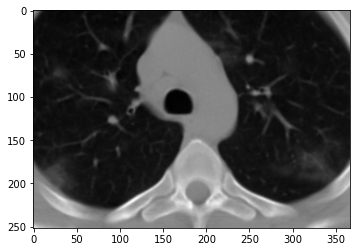

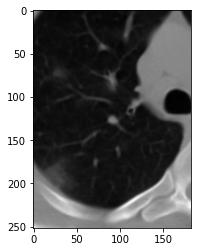

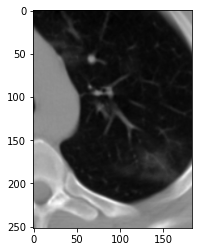

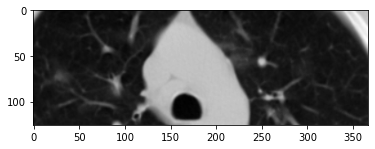

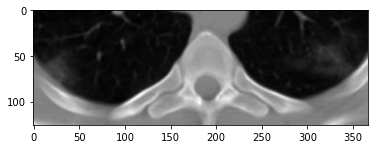

In [8]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        print("Resolution:")
        print(img_array.shape[1],"x",img_array.shape[0])
        plt.imshow(img_array, cmap="gray")
        plt.show()

        LH_img = img_array[: , :int(img_array.shape[1]/2)]
        plt.imshow(LH_img, cmap="gray")
        plt.show()
        

        RH_img = img_array[: , int(img_array.shape[1]/2):]
        plt.imshow(RH_img, cmap="gray")
        plt.show()

        TH_img = img_array[:int(img_array.shape[0]/2) , :]
        plt.imshow(TH_img, cmap="gray")
        plt.show()

        BH_img = img_array[int(img_array.shape[0]/2): , :]
        plt.imshow(BH_img, cmap="gray")
        plt.show()



        break
    break

In [9]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    #raw_image = []
    row_sum = []
    coloumn_sum = []
    
    LH_sum = []
    RH_sum = []
    
    TC_sum = []
    BC_sum =[]

    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):

            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=0)
                coloumn = img_array.sum(axis=1)

                row_sum.append(row)
                coloumn_sum.append(coloumn)

                LH_img = img_array[: , :int(img_array.shape[1]/2)]
                LH_sum.append(LH_img.sum(0))

                RH_img = img_array[: , int(img_array.shape[1]/2):]
                RH_sum.append(RH_img.sum(0))

                TC_img = img_array[:int(img_array.shape[0]/2) , :]
                TC_sum.append(TC_img.sum(1))

                BC_img = img_array[int(img_array.shape[0]/2): , :]
                BC_sum.append(BC_img.sum(1))

                
                #raw_image.append(img_array)

                

                label.append(class_num)
                
            except Exception as e:
                pass
    
    #df_data["raw data"] = raw_image
    df_data["row_sum"] = row_sum
    df_data["coloumn_sum"] = coloumn_sum

    df_data["LH_sum"] = LH_sum
    df_data["RH_sum"] = RH_sum
    df_data["TC_sum"] = TC_sum
    df_data["BC_sum"] = BC_sum

    df_data["label"] = label
    
    return df_data

In [10]:
dataset_df = pre_process_dataset(DATADIR)

Loading dataset: class covid


  0%|          | 0/5719 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/5514 [00:00<?, ?it/s]

In [11]:
dataset_df.head(5)

,row_sum,coloumn_sum,LH_sum,RH_sum,TC_sum,BC_sum,label
0,"[12868, 12523, 12192, 11946, 11733, 11461, 112...","[10936, 10780, 10654, 10588, 10564, 10593, 105...","[12868, 12523, 12192, 11946, 11733, 11461, 112...","[27062, 27247, 27473, 27571, 27562, 27492, 274...","[10936, 10780, 10654, 10588, 10564, 10593, 105...","[15097, 14816, 14426, 13831, 13337, 12948, 126...",0
1,"[36184, 36414, 36553, 36656, 36729, 36860, 371...","[55967, 56111, 56305, 56494, 56637, 56789, 569...","[36184, 36414, 36553, 36656, 36729, 36860, 371...","[42076, 42072, 42112, 42367, 42692, 43079, 434...","[55967, 56111, 56305, 56494, 56637, 56789, 569...","[57362, 57184, 56953, 56828, 56797, 56707, 564...",0
2,"[37746, 37912, 38173, 38320, 38385, 38422, 385...","[54067, 53512, 53303, 53342, 52215, 50208, 484...","[37746, 37912, 38173, 38320, 38385, 38422, 385...","[39409, 39221, 39043, 38963, 38897, 38937, 389...","[54067, 53512, 53303, 53342, 52215, 50208, 484...","[47916, 47740, 47238, 46564, 46066, 45997, 463...",0
3,"[26314, 26321, 26459, 26562, 26715, 26737, 267...","[35673, 35586, 35684, 35815, 35816, 35884, 360...","[26314, 26321, 26459, 26562, 26715, 26737, 267...","[27961, 27999, 28161, 28175, 28188, 28447, 286...","[35673, 35586, 35684, 35815, 35816, 35884, 360...","[20232, 20370, 20416, 20374, 20255, 20358, 205...",0
4,"[24059, 24365, 24695, 24737, 24813, 24900, 254...","[29136, 28924, 28811, 28714, 28914, 29077, 292...","[24059, 24365, 24695, 24737, 24813, 24900, 254...","[29542, 29645, 29711, 30074, 31000, 32193, 326...","[29136, 28924, 28811, 28714, 28914, 29077, 292...","[12274, 11976, 11902, 12194, 12850, 12806, 122...",0


In [12]:
df_train, df_val = train_test_split(dataset_df, test_size=0.2, random_state=0)

In [13]:
df_train["label"].value_counts()

0    4601
1    4385
Name: label, dtype: int64

In [14]:
print("No of Training samples:",len(df_train))
print("No of Validation samples:",len(df_val))

No of Training samples: 8986
No of Validation samples: 2247


In [15]:
df_train.head()

,row_sum,coloumn_sum,LH_sum,RH_sum,TC_sum,BC_sum,label
6402,"[35648, 35652, 35647, 35632, 35657, 35754, 359...","[50967, 51246, 51486, 51683, 51900, 52143, 524...","[35648, 35652, 35647, 35632, 35657, 35754, 359...","[36395, 36248, 36106, 35965, 35796, 35666, 355...","[50967, 51246, 51486, 51683, 51900, 52143, 524...","[37898, 38153, 38371, 38476, 38409, 38208, 379...",1
5566,"[22757, 22760, 24005, 24580, 23954, 23664, 235...","[16660, 16893, 17214, 17383, 17305, 17407, 175...","[22757, 22760, 24005, 24580, 23954, 23664, 235...","[23417, 23517, 23762, 23827, 23702, 23346, 232...","[16660, 16893, 17214, 17383, 17305, 17407, 175...","[15726, 15638, 15473, 14872, 14605, 15008, 153...",0
4555,"[53779, 53701, 54367, 54158, 54212, 54259, 547...","[64693, 63083, 61182, 59350, 57680, 56278, 552...","[53779, 53701, 54367, 54158, 54212, 54259, 547...","[52401, 53797, 54677, 54963, 54981, 55017, 545...","[64693, 63083, 61182, 59350, 57680, 56278, 552...","[47675, 48522, 48309, 48814, 49177, 48748, 481...",0
6386,"[35112, 33689, 32804, 32341, 32010, 31758, 315...","[29369, 31044, 32266, 32912, 33273, 33592, 339...","[35112, 33689, 32804, 32341, 32010, 31758, 315...","[35821, 35765, 35853, 36200, 36463, 36358, 360...","[29369, 31044, 32266, 32912, 33273, 33592, 339...","[38356, 38459, 38539, 38584, 38682, 38832, 389...",1
1499,"[19555, 18725, 18034, 17600, 17200, 16894, 167...","[39019, 39035, 39107, 39028, 38869, 38859, 389...","[19555, 18725, 18034, 17600, 17200, 16894, 167...","[30484, 30837, 30971, 31002, 31073, 31261, 317...","[39019, 39035, 39107, 39028, 38869, 38859, 389...","[36904, 36806, 36849, 36807, 36829, 36509, 360...",0


In [16]:
from sklearn import preprocessing

def process_data(dataset_df):
    
    row = dataset_df["row_sum"].values
    coloumn = dataset_df["coloumn_sum"].values

    LH = dataset_df["LH_sum"].values
    RH = dataset_df["RH_sum"].values
    TC = dataset_df["TC_sum"].values
    BC = dataset_df["BC_sum"].values


    X1 = [img.tolist() for img in row]
    X2 = [img.tolist() for img in coloumn]

    X3 = [img.tolist() for img in LH]
    X4 = [img.tolist() for img in RH]
    X5 = [img.tolist() for img in TC]
    X6 = [img.tolist() for img in BC]


    #for img in dataset:
        #X.append(img.tolist())
    X1 = np.array(X1)
    X2 = np.array(X2)

    X3 = np.array(X3)
    X4 = np.array(X4)
    X5 = np.array(X5)
    X6 = np.array(X6)


    X1 = preprocessing.normalize(X1)
    X2 = preprocessing.normalize(X2)
    X3 = preprocessing.normalize(X3)
    X4 = preprocessing.normalize(X4)
    X5 = preprocessing.normalize(X5)
    X6 = preprocessing.normalize(X6)


    X1 = np.expand_dims(X1, axis=-1)
    X2 = np.expand_dims(X2, axis=-1)
    X3 = np.expand_dims(X3, axis=-1)
    X4 = np.expand_dims(X4, axis=-1)
    X5 = np.expand_dims(X5, axis=-1)
    X6 = np.expand_dims(X6, axis=-1)



    y = np.array(dataset_df["label"].values)
    y = np.expand_dims(y, axis=-1)


    print("X1 shape", X1.shape)
    print("X2 shape", X2.shape)
    print("X3 shape", X3.shape)
    print("X4 shape", X4.shape)
    print("X5 shape", X5.shape)
    print("X6 shape", X6.shape)

    print("y shape", y.shape)

    return X1, X2, X3, X4, X5, X6, y

In [17]:
print("Training samples:")
X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, Y_train = process_data(df_train)

print("\nValidation samples:")
X1_val, X2_val, X3_val, X4_val, X5_val, X6_val, Y_val = process_data(df_val)


Training samples:
X1 shape (8986, 367, 1)
X2 shape (8986, 252, 1)
X3 shape (8986, 183, 1)
X4 shape (8986, 184, 1)
X5 shape (8986, 126, 1)
X6 shape (8986, 126, 1)
y shape (8986, 1)

Validation samples:
X1 shape (2247, 367, 1)
X2 shape (2247, 252, 1)
X3 shape (2247, 183, 1)
X4 shape (2247, 184, 1)
X5 shape (2247, 126, 1)
X6 shape (2247, 126, 1)
y shape (2247, 1)


In [18]:
# first input model
visible1 = Input(shape=(367, 1))
conv11 = Conv1D(64, kernel_size=3, activation='relu')(visible1)
conv12 = Conv1D(64, kernel_size=3, activation='relu')(conv11)
drop11 = Dropout(0.25)(conv12)
pool11 = MaxPooling1D(pool_size=2)(drop11)
flat1 = Flatten()(pool11)


# second input model
visible2 = Input(shape=(252, 1))
conv21 = Conv1D(64, kernel_size=3, activation='relu')(visible2)
conv22 = Conv1D(64, kernel_size=3, activation='relu')(conv21)
drop21 = Dropout(0.25)(conv22)
pool21 = MaxPooling1D(pool_size=2)(drop21)
flat2 = Flatten()(pool21)

# merge input models
merge = concatenate([flat1, flat2])

hidden1 = Dense(100, activation='relu')(merge)
hidden2 = Dense(100, activation='relu')(hidden1)

#####################################################################

visible3 = Input(shape=(183, 1))
conv31 = Conv1D(64, kernel_size=3, activation='relu')(visible3)
conv32 = Conv1D(64, kernel_size=3, activation='relu')(conv31)
drop31 = Dropout(0.25)(conv32)
pool31 = MaxPooling1D(pool_size=2)(drop31)
flat3 = Flatten()(pool31)

visible4 = Input(shape=(184, 1))
conv41 = Conv1D(64, kernel_size=3, activation='relu')(visible4)
conv42 = Conv1D(64, kernel_size=3, activation='relu')(conv41)
drop41 = Dropout(0.25)(conv42)
pool41 = MaxPooling1D(pool_size=2)(drop41)
flat4 = Flatten()(pool41)

# merge input models
merge1 = concatenate([flat3, flat4])
hidden3 = Dense(100, activation='relu')(merge1)
hidden4 = Dense(100, activation='relu')(hidden3)


visible5 = Input(shape=(126, 1))
conv51 = Conv1D(64, kernel_size=3, activation='relu')(visible5)
conv52 = Conv1D(64, kernel_size=3, activation='relu')(conv51)
drop51 = Dropout(0.25)(conv52)
pool51 = MaxPooling1D(pool_size=2)(drop51)
flat5 = Flatten()(pool51)

visible6 = Input(shape=(126, 1))
conv61 = Conv1D(64, kernel_size=3, activation='relu')(visible6)
conv62 = Conv1D(64, kernel_size=3, activation='relu')(conv61)
drop61 = Dropout(0.25)(conv62)
pool61 = MaxPooling1D(pool_size=2)(drop61)
flat6 = Flatten()(pool61)

merge2 = concatenate([flat5, flat6])
hidden5 = Dense(100, activation='relu')(merge2)
hidden6 = Dense(100, activation='relu')(hidden5)

# merge input models
merge3 = concatenate([hidden4, hidden6])
merge4 = concatenate([hidden2, merge3])

output = Dense(1, activation='sigmoid')(merge4)
model = Model(inputs=[visible1, visible2, visible3, visible4, visible5, visible6], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 183, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 184, 1)]     0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 126, 1)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 126, 1)]     0           []                               
                                                                                              

In [4]:
# first input model
visible1 = Input(shape=(512,1))
conv11 = Conv1D(64, kernel_size=3, activation='relu')(visible1)

conv12 = Conv1D(64, kernel_size=3, activation='relu')(conv11)
drop11 = Dropout(0.25)(conv12)
pool11 = MaxPooling1D(pool_size=2)(drop11)
flat1 = Flatten()(pool11)


# second input model

visible2 = Input(shape=(512,1))
conv21 = Conv1D(64, kernel_size=3, activation='relu')(visible2)
conv22 = Conv1D(64, kernel_size=3, activation='relu')(conv21)
drop21 = Dropout(0.25)(conv22)
pool21 = MaxPooling1D(pool_size=2)(drop21)
flat2 = Flatten()(pool21)


# merge input models
merge = concatenate([flat1, flat2])
# interpretation model
hidden1 = Dense(100, activation='relu')(merge)
hidden2 = Dense(100, activation='relu')(hidden1)

output = Dense(1, activation='sigmoid')(hidden2)
model = Model(inputs=[visible1, visible2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512, 1)]     0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 512, 1)]     0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 510, 64)      256         ['input_13[0][0]']               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 510, 64)      256         ['input_14[0][0]']               
                                                                                            

In [19]:

BATCH_SIZE = 128
EPOCHS = 500
history = model.fit(
    [X1_train, X2_train, X3_train, X4_train, X5_train, X6_train],
    Y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_data=([X1_val, X2_val, X3_val, X4_val, X5_val, X6_val], Y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/"+model_name+".h5")

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
71/71 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.6705WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002CED941B678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

# Evaluate the Model using test data

In [20]:
Test_DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/test"
dataset_df = pre_process_dataset(Test_DATADIR)

Loading dataset: class covid


  0%|          | 0/1430 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/1379 [00:00<?, ?it/s]

In [21]:
print("No of test sample:", len(dataset_df))

No of test sample: 2809


In [22]:
X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, Y_test = process_data(dataset_df)

X1 shape (2809, 367, 1)
X2 shape (2809, 252, 1)
X3 shape (2809, 183, 1)
X4 shape (2809, 184, 1)
X5 shape (2809, 126, 1)
X6 shape (2809, 126, 1)
y shape (2809, 1)


In [23]:
# test loss, test accuracy
accuracy = model.evaluate([X1_test, X2_test, X3_test, X4_test, X5_test, X6_test], Y_test, batch_size=100, verbose=0)

In [24]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9394802451133728
Test loss 0.3374931812286377


In [25]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict([X1_test, X2_test, X3_test, X4_test, X5_test, X6_test]) > 0.5).astype("int32")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
88/88 [==============================] - 3s 20ms/step


## with resizing

In [23]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.94      0.97      0.95      1430
      Normal       0.96      0.94      0.95      1379

    accuracy                           0.95      2809
   macro avg       0.95      0.95      0.95      2809
weighted avg       0.95      0.95      0.95      2809



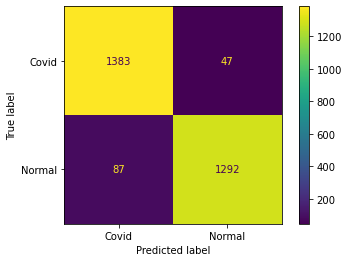

In [24]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()


## without re-sizing

In [26]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.93      0.96      0.94      1430
      Normal       0.95      0.92      0.94      1379

    accuracy                           0.94      2809
   macro avg       0.94      0.94      0.94      2809
weighted avg       0.94      0.94      0.94      2809



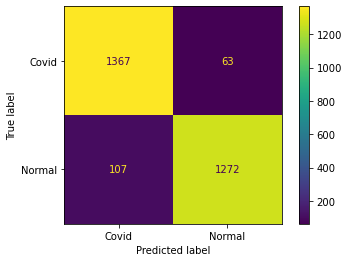

In [27]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
